In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, sosfilt, sosfreqz

In [2]:
def dipole_response(theta, dist, theta_v, dist_v, headsize=0.18, c=343, fs=44100):
    """
    Dipole 3D audio filter design for speaker crosstalk cancellation
    :param theta: Angle between symmetrical speakers in degrees.
    :param dist: Distance to loudspeakers in meters.
    :param theta_v: Angle between center and virtual source in degrees.
    :param dist_v: Distance to virtual source in meters.
    :param headsize: Diameter in meters.
    :param c: Speed of sound.
    :param fs: Sample rate.
    :return: IIR filter coefficients.
    """

    # Compute geometry source
    path_diff = np.sin(np.radians(theta) / 2) * headsize  # approximated geometric model
    tao = path_diff / c  # in seconds
    g = dist / (dist + path_diff) # IID attenuation from speaker distance and angle
    n = int(round(tao * fs)) # cross-delay length

    # Compute virtual source
    path_diff_v = np.sin(np.radians(theta_v) * headsize)  # approximated geometric model
    tao_v = path_diff_v / c  # in seconds
    g_v = dist_v / (dist_v + path_diff_v) # IID attenuation from virtual distance and virtual source
    n_v = int(round(tao_v * fs))

    # Compute Dipole IIR filter
    total_tao = n + n_v
    total_delay_line = 2 * n + total_tao  # memory allocation at worst case filter order

    # Compute denominator
    a = np.zeros(total_delay_line + 1)
    a[0] = 1.0
    a[2 * n] = -g * g

    # Compute Ipsilateral numerator - comb
    b_ipsi = np.zeros(total_delay_line + 1)
    b_ipsi[0] = 1.0
    b_ipsi[total_tao] -= g * g_v

    # Compute Contralateral numerator - comb combined with cross-talk
    b_cont = np.zeros(total_delay_line + 1)
    b_cont[n] = -g
    b_cont[n_v] += g_v

    return b_ipsi, b_cont, a

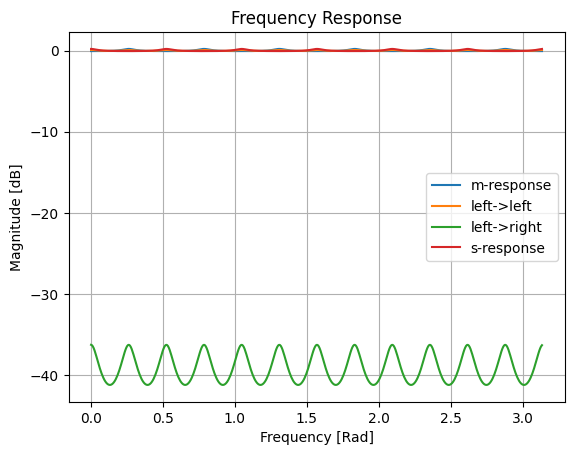

In [3]:
b_ipsi, b_cont, a = dipole_response(60, 0.1, 30, 0.1)

w, h = freqz(b_ipsi + b_cont, a)
plt.plot(w, 20 * np.log10(abs(h)), label='m-response')

w, h = freqz(b_ipsi, a)
plt.plot(w, 20 * np.log10(abs(h)), label='left->left')

w, h = freqz(b_cont, a)
plt.plot(w, 20 * np.log10(abs(h)), label='left->right')

w, h = freqz(b_ipsi - b_cont, a)
plt.plot(w, 20 * np.log10(abs(h)), label='s-response')

plt.legend()
plt.xlabel('Frequency [Rad]')
plt.ylabel('Magnitude [dB]')
plt.title('Frequency Response')
plt.grid()
plt.show()